# DSTI ML Project A22 Cohort: Book Rating Predictor
The aim of the project is to train and evaluate different models that predict a book’s rating from a GoodReads dataset

In [1]:
# Ensure to select the .venv-book kernel before importing
# Kernel > Change kernel > .venv-book

import datetime

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

from sklearn import preprocessing

## 1) Exploratory Analysis

In [2]:
df = pd.read_csv("../data/books.csv", on_bad_lines='skip')
print(f"Dataset contains: {df.shape[0]} rows and {df.shape[1]} columns")
# Clean the columns name
for col in df.columns:
    df = df.rename(columns = {col: col.strip()})
df.head()

Dataset contains: 11123 rows and 12 columns


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


### 1.1) Null Values and Data Types

In [3]:
print(f"Is there any nul values present in dataset: {df.isnull().values.any()}")
df.isna().sum()

Is there any nul values present in dataset: False


bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

We do not have null values in any columns as shown above => Dataset is "clean"

In [4]:
x = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7   num_pages           11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


Unfortunately, we find that we have some columns of "object" type, but they are probably of string types, we will have to check and set the types of the columns properly.

### 1.2) Unique Identifiers
We now want to check for unique values in each variables because we have some variables that act as "*unique identifiers*" such as:
- ```isbn```
- ```isbn13```
- ```bookID```

These variables do not need a rigorous "analysis"

In [5]:
unique_identifiers = []
table = []
print(f"Number of rows: {len(df)}")
for var in df.columns:
    table.append([var, len(df[var].unique())])
    if len(df[var].unique())/len(df) == 1:
        unique_identifiers.append(var)

print(f"Unique Identifiers: {unique_identifiers}")
pd.DataFrame(table, columns=["var", "unique_count"])

Number of rows: 11123
Unique Identifiers: ['bookID', 'isbn', 'isbn13']


,var,unique_count
0,bookID,11123
1,title,10348
2,authors,6639
3,average_rating,209
4,isbn,11123
5,isbn13,11123
6,language_code,27
7,num_pages,997
8,ratings_count,5294
9,text_reviews_count,1822


### 1.3) Numeric, Non-numeric and Categorical variables

In [6]:
numeric_vars = []
non_numeric_vars = []
table= []
for col, _type in zip(list(df.columns), list(df.dtypes)):
    if _type != object: #TODO make a more rigorous check
        numeric_vars.append(col)
        table.append([col, _type])
    else:
        non_numeric_vars.append(col)

print("Numeric variables:")
pd.DataFrame(table, columns=["Variable", "Type"])

Numeric variables:


,Variable,Type
0,bookID,int64
1,average_rating,float64
2,isbn13,int64
3,num_pages,int64
4,ratings_count,int64
5,text_reviews_count,int64


We found 6 numeric variables (including the target) and 6 non-numeric variables

### 1.4) Study of non-numeric variables & Pre-processing Technique

In [7]:
df[non_numeric_vars].describe()

,title,authors,isbn,language_code,publication_date,publisher
count,11123,11123,11123,11123,11123,11123
unique,10348,6639,11123,27,3679,2290
top,The Iliad,Stephen King,0439785960,eng,10/1/2005,Vintage
freq,9,40,1,8908,56,318


#### 1.4.1) Study of ```isbn```

Before we proceed, after some research we found that the variable ```isbn``` is supposed to be numeric values similar to the ```isbn13```, but it seems that the column has been polluted with non-numeric values hence causing the column to be identified with dtype = object.\
This is shown in the following

In [8]:
#Check for non-numeric isbn
non_numeric_isbn = []
numeric_isbn = []
for index, row in df.iterrows():
    try:
        int(row["isbn"])
        numeric_isbn.append(row["isbn"])
    except Exception as e:
        non_numeric_isbn.append(row["isbn"])

print(f"Numeric isbn: {len(numeric_isbn)}")
print(f"Non-numeric isbn: {len(non_numeric_isbn)}")
print(f"For e.g.: {non_numeric_isbn[0:5]}")

Numeric isbn: 10139
Non-numeric isbn: 984
For e.g.: ['043965548X', '076790818X', '076790382X', '097669400X', '006076273X']


We identify 984 rows with non-standard ```isbn``` and the number is too large to drop those rows.

After some research we found that:\
*Technically, books published earlier than January 2007 have both ISBN-1o and ISBN-13. Books published later than January 2007 have only ISBN-13. Basically, a book’s ISBN-10 and ISBN-13 are two similar sets of numbers. Their middle numbers are the same, but they differ in length and have different beginning numbers and check digits (last numbers).*

ref: https://bookscouter.com/tips/isbn-10-vs-isbn-13-whats-the-difference/

Therefore, we conclude that instead of loosing time and resources to clean the ```isbn``` column, we will drop the column and use only the ```isbn13``` to prevent redundancy in the features

#### 1.4.2) Study of ```language_code```

For the ```title```,  ```authors``` and  ```publisher``` columns, they are pure texts and can be verified with the same algorithm used above.
We will study the ```language_code``` variable because it has a fairly small number of categories compared to the others.

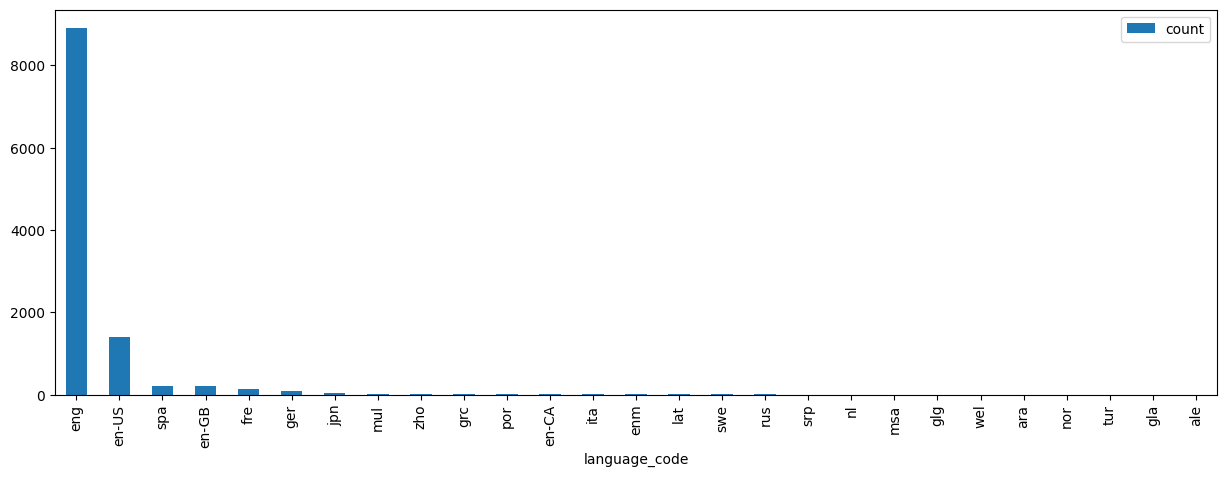

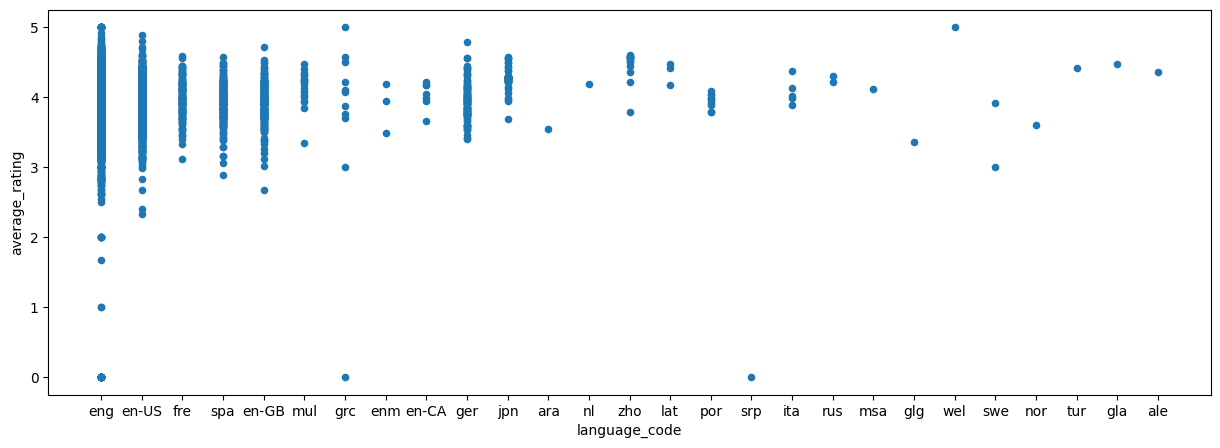

In [9]:
# Barplot of language
df['language_code'].value_counts().plot(kind='bar', figsize=(15, 5)).legend()
# Scatter plot
df.plot.scatter(x="language_code", y="average_rating", figsize=(15,5))
plt.show()

i) From the barplot we find that the ```language_code``` variable is dominated by the english language (with variations of english). Due to the lack of data for other languages, we will probably regroup all variations of english and consider:
- Either only english, spanish, french and others & use **One-Hot Encoding** (4 dummies)
- Or only english and others & use **One-Hot Encoding** (2 dummies)

ii) From the scatter plot we find that the target ```average_rating``` does not really depend on the language code, as most of them fall between 2.5 and 5 

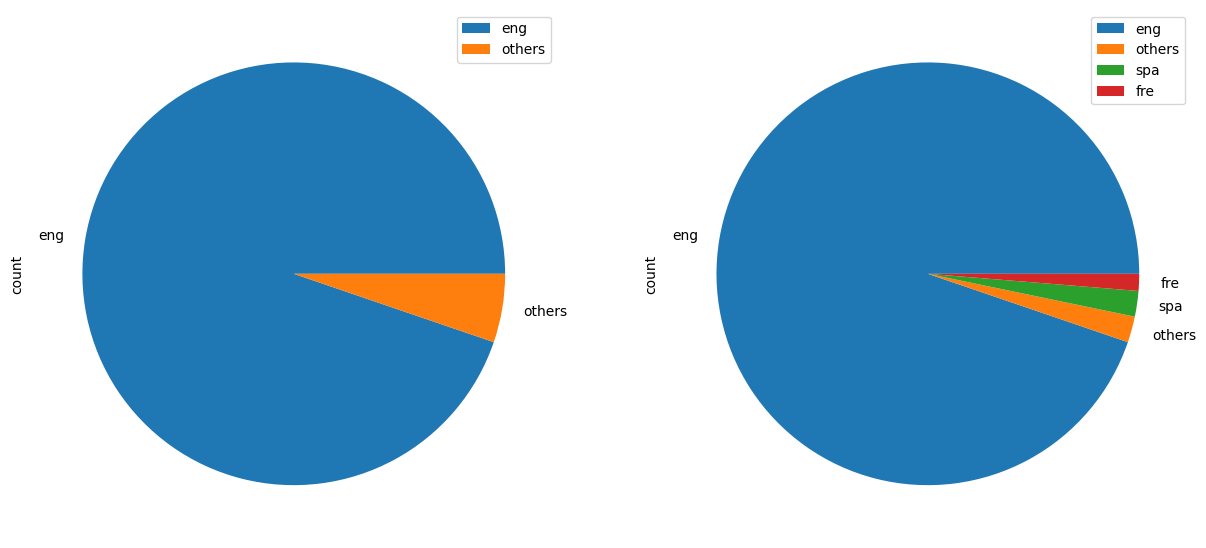

In [10]:
df_2_dummies = df.copy()
df_4_dummies = df.copy()

for index, row in df_2_dummies.iterrows():
    if "en" in row["language_code"]:
        df_2_dummies.loc[index, "language_code"] =  "eng"
    else:
        df_2_dummies.loc[index, "language_code"] = "others"

for index, row in df_4_dummies.iterrows():
    if "en" in row["language_code"]:
        df_4_dummies.loc[index, "language_code"] =  "eng"
    elif row["language_code"] not in ["spa", "fre"]:
        df_4_dummies.loc[index, "language_code"] = "others"

fig, (ax1, ax2) = plt.subplots(1,2)
df_2_dummies['language_code'].value_counts().plot(kind='pie', figsize=(15, 10), ax=ax1).legend()
df_4_dummies['language_code'].value_counts().plot(kind='pie', figsize=(15, 10), ax=ax2).legend()
plt.show()


From the above pie charts, we clearly see that the volume of books written in english (not matter which english) is way bigger than books written in other languages, **hence we will opt for only two dummies for our model (english and others)**

#### 1.4.3) Study of ```publication_date```
Before we can see how the publication date affect the target variable, we will need to check the validity of all date values

In [11]:
# Check for valid dates
df_date_trans = df.copy()
invalid_date = []
for index, row in df_date_trans.iterrows():
    p_date = df_date_trans.loc[index, "publication_date"]
    try:
        p_date2 = datetime.datetime.strptime(p_date,'%m/%d/%Y').date()
    except Exception as e:
        invalid_date.append([index, p_date, e])

pd.DataFrame(invalid_date, columns=["index", "date", "error"])

,index,date,error
0,8177,11/31/2000,day is out of range for month
1,11094,6/31/1982,day is out of range for month


In [12]:
# Remove invalid dates
print(f"Before removing invalid dates: {len(df_date_trans)}")
for id in invalid_date:
    df_date_trans = df_date_trans.drop([id[0]])
print(f"After removing invalid dates: {len(df_date_trans)}")

Before removing invalid dates: 11123
After removing invalid dates: 11121


In [13]:
# Set dates in appropriate date format
for index, row in df_date_trans.iterrows():
    p_date = df_date_trans.loc[index, "publication_date"]
    p_date2 = datetime.datetime.strptime(p_date,'%m/%d/%Y').date()
    df_date_trans.loc[index, "publication_date"] = p_date2

df_date_trans["publication_date"].describe()

count          11121
unique          3677
top       2005-10-01
freq              56
Name: publication_date, dtype: object

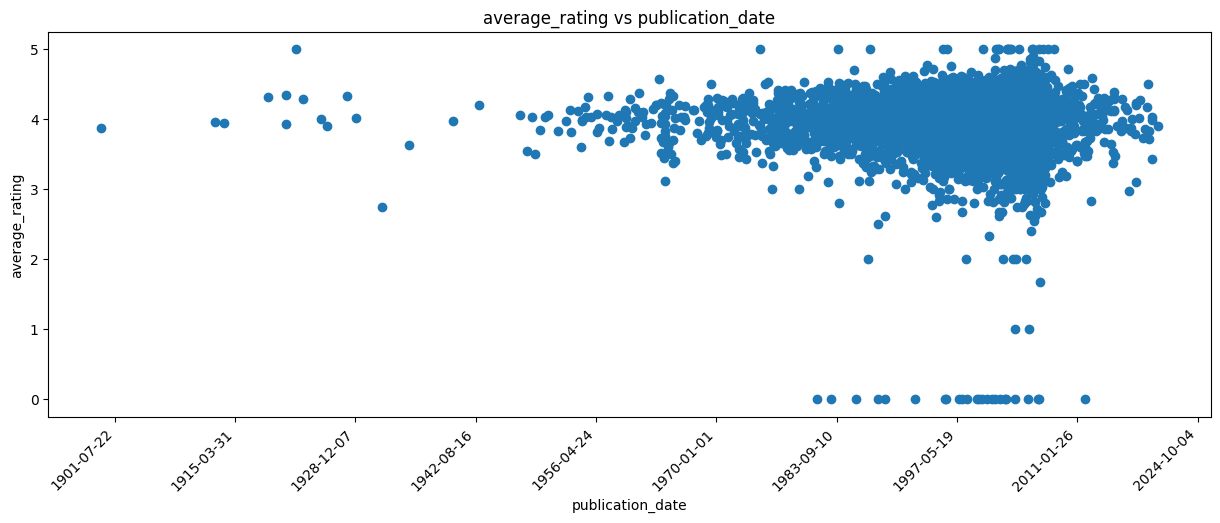

In [14]:
# Ratings v/s publication_date
max_xticks = 10
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.scatter(df_date_trans["publication_date"],df_date_trans["average_rating"])
ax.xaxis.set_major_locator(tkr.MaxNLocator(max_xticks))

plt.title("average_rating vs publication_date")
plt.xlabel("publication_date")
plt.ylabel("average_rating")
plt.xticks(rotation=45, ha='right')
plt.show()

There is no apparent relationship between the target and the publicaton date and we cannot draw a proper conclusion on how the ```publication_date``` affects the ```average_rating```.

#### 1.4.4) Study of ```authors```
We can see within the first rows of the dataset that we have several authors for some books that are separated by a "/", the idea would be to split them and see how it affects the target value.

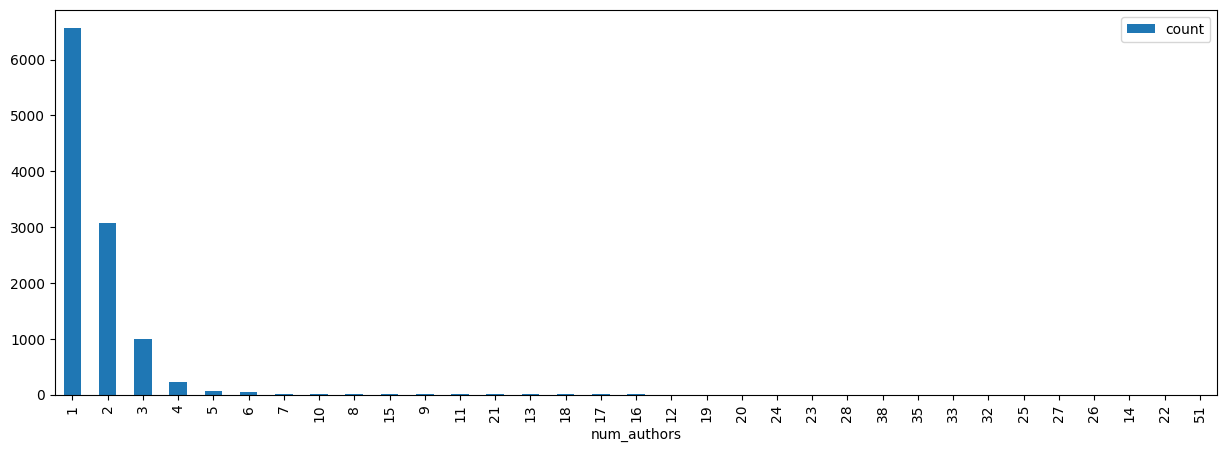

In [15]:
df_authors_split = df.copy()
for index, row in df_authors_split.iterrows():
    df_authors_split.loc[index, "num_authors"] = len(row["authors"].split("/"))

df_authors_split["num_authors"] = df_authors_split["num_authors"].astype(int)
df_authors_split = df_authors_split.sort_values("num_authors")
df_authors_split["num_authors"].value_counts().plot(kind='bar', figsize=(15, 5)).legend()
plt.show()

As we can see in the above barplot, some books have a large number of authors and beyond 3 authors we have very few data, hence we will split the authors column into the first two authors and will discard all the authors beyond that but we will add the number of authors for each book:

```authors``` --> ```author1``` + ```author2``` + ```num_authors```

In [16]:
df_authors_split = df.copy()
for index, row in df_authors_split.iterrows():
    authors = row["authors"].split("/")
    df_authors_split.loc[index, "num_authors"] = len(authors)
    for i, author in enumerate(authors[0:2]):
        df_authors_split.loc[index, f"author_{i+1}"] = author

df_authors_split["num_authors"] = df_authors_split["num_authors"].astype(int)
df_authors_split.head(3)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,num_authors,author_1,author_2
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,2,J.K. Rowling,Mary GrandPré
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,2,J.K. Rowling,Mary GrandPré
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,1,J.K. Rowling,NaN


<Axes: xlabel='num_authors', ylabel='average_rating'>

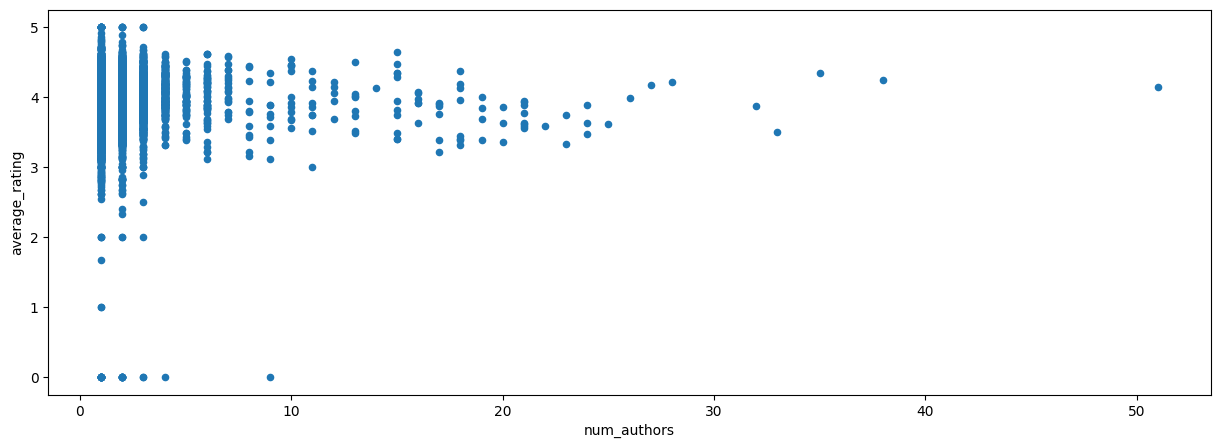

In [17]:
# Scatter plot
df_authors_split.plot.scatter(x="num_authors", y="average_rating", figsize=(15,5))

We can see that there is not much relationship between both variables

#### 1.4.5) Study of the ```title```

We have 10348 unique titles over 11123, hence it may not have much impact on the target variable, hence we will use Label Encoding to encode the large number of "categories". 

We can also extract the length of the titles also, assuming that maybe the length of the titles may affect whether someone will read the book or not.

```title``` --> ```title``` + ```title_len```

<Axes: xlabel='title_len', ylabel='average_rating'>

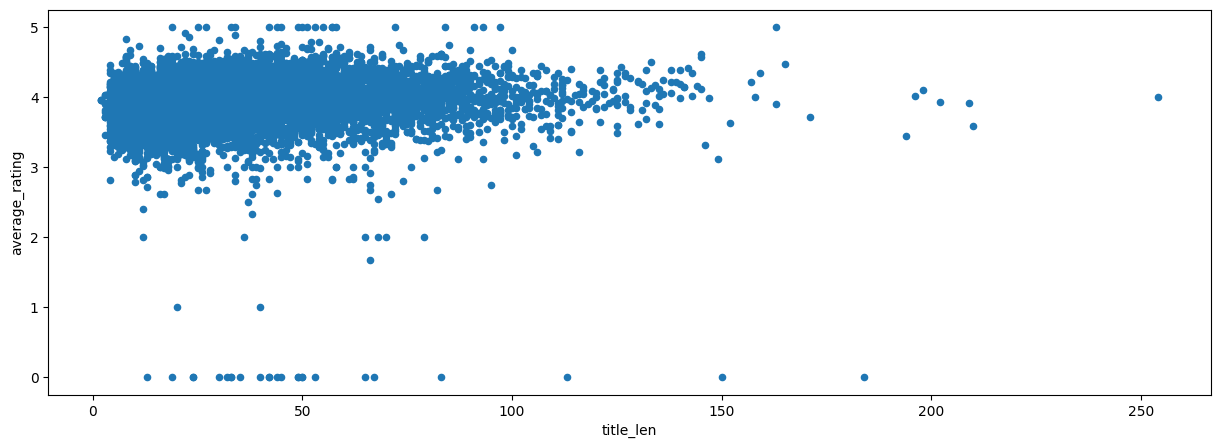

In [18]:
df_len_title = df.copy()
for index, row in df_len_title.iterrows():
    df_len_title.loc[index, "title_len"] = len(row["title"])

df_len_title["title_len"] = df_len_title["title_len"].astype(int)

# Scatter plot
df_len_title.plot.scatter(x="title_len", y="average_rating", figsize=(15,5))

Again we cannot conclude much, but at least we are enriching our set of features and later will be able to see how it affects the target and the training

#### 1.4.5) Preprocessing of non-numeric variables
For the ```title```,  ```authors``` and  ```publisher``` variables we will use **Label Encoding** as they have a large number of "categories". We can note also that the ```title``` and  ```authors``` columns will not have much impact on the target variable due to the very large number of "categories" and hence may not be useful to train the model. However we obtained a numerical feature ```num_authors``` and ```title_len``` which may be useful to the model.

For the ```publication_date``` we will convert the date into a continuous variable by subtracting all the dates from a reference date.

As seen previously, we will drop the ```isbn``` column.

| Variable | Pre-processing
| --- | --- |
| ```language_code``` -> ```eng``` + ```others``` | One-Hot Encoding |
| ```title``` -> ```title``` + ```title_len``` | Label Encoding |
| ```authors``` -> ```author1``` + ```author2``` + ```num_authors``` | Split authors & Label Encoding |
| ```publisher``` | Label Encoding |
| ```publication_date``` | Date Transformation to continuous values|
| ```isbn``` | Drop |

### 1.5) Study of numeric variables & Pre-processing Technique

In [19]:
df[numeric_vars].describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


#### 1.5.1) Study of Skewness (Histogram & Normal Curve)
Defining a helper function to visualize the numeric variables

In [20]:
def plot_hist_norm(
        feature: pd.DataFrame, 
        feature_name: str,
        bins: int = 100,
        color: str = 'b'
) -> None:
    """Plot Normal curve overlayed on a histogram of a column from a pandas DataFrame
    Ref: https://github.com/kart-projects/Goodreads-books/blob/master/DataExploration.ipynb

    Args:
        feature (pd.DataFrame): 
        feature_name (str): 
        bins (int, optional): Defaults to 20.
        color (str, optional): Defaults to 'b'.
    """
    dMean, dStd = norm.fit(feature)
    plt.figure(figsize = (8, 4))
    plt.hist(feature, bins, density=True, alpha=0.6, color=color)
    xmin, xmax = plt.xlim()
    xlin = np.linspace(xmin, xmax, 100)
    pdf = norm.pdf(xlin, dMean, dStd)
    plt.plot(xlin, pdf, 'k', linewidth=2)
    title = f"{feature_name}\nmean = {dMean:.4f} & std = {dStd:.4f}"
    plt.title(title)
    plt.show()

/!\ Note that it does not make sense to plot the variables ```bookID``` and ```isbn13``` since they act like unique identifiers

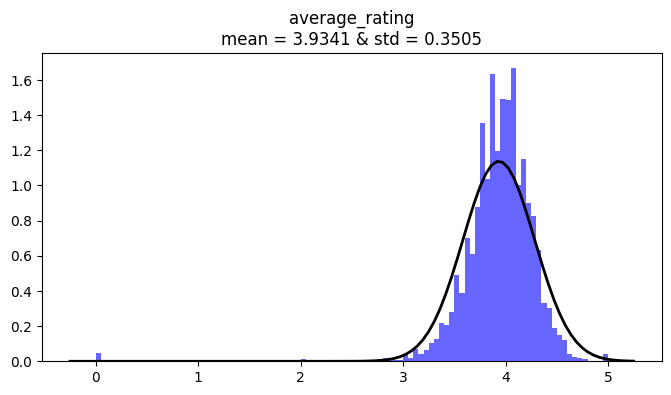

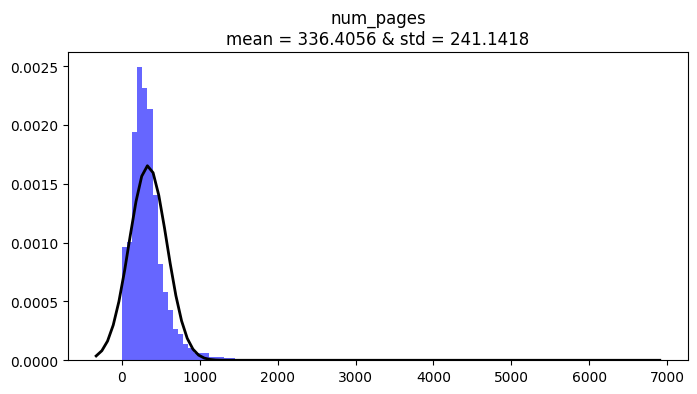

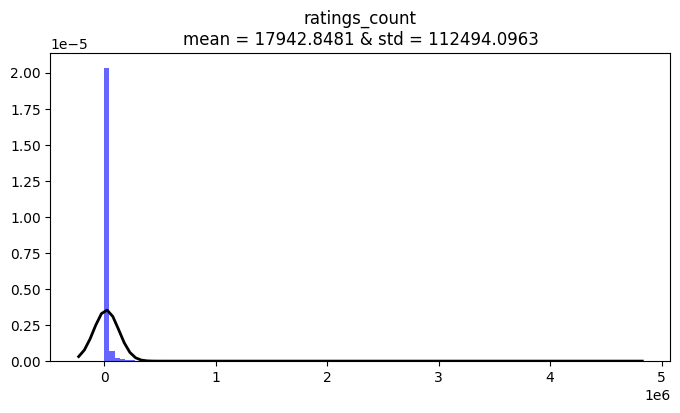

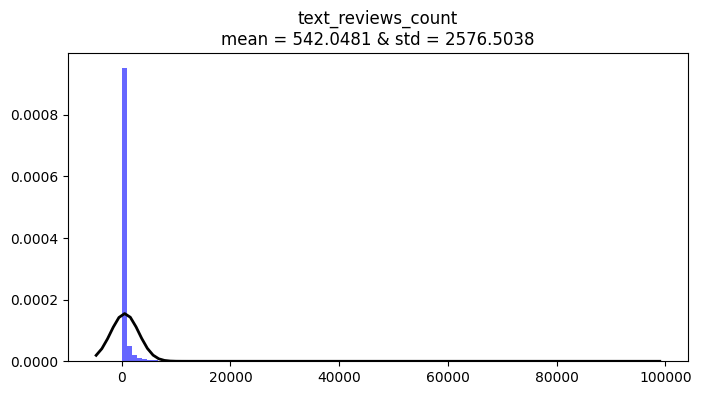

In [21]:
for var in numeric_vars:
    if var not in unique_identifiers:
        plot_hist_norm(df[var], var)

Analysis:
- ```average_ratings``` (target): Normally distributed around the value 4
- ```ratings_count```: Left skewed (presence of outliers)
- ```text_reviews_count```: Left skewed (presence of outliers)
- ```num_pages```: Left skewed (presence of outliers)

The skewness of the variables may indicated presence of extreme outliers.

#### 1.5.2) Study of Outliers (Boxplot)
A boxplot will help us better visualize and identify the outliers after normalizing the values of each variables

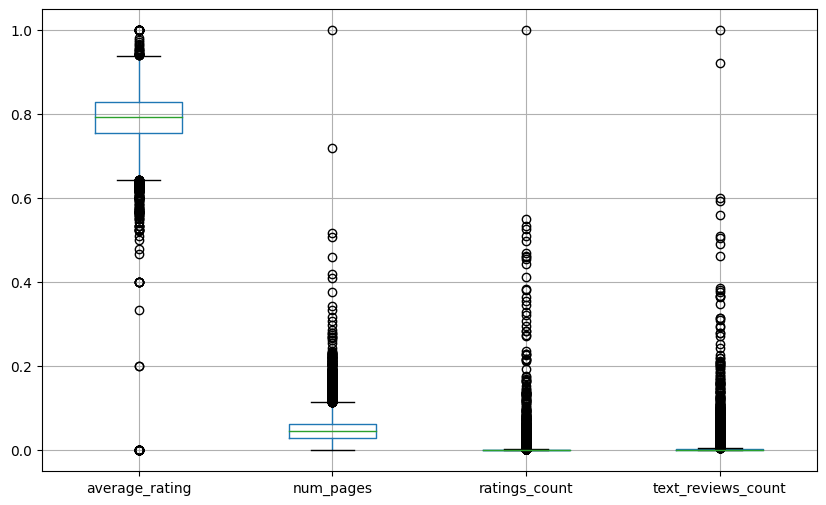

In [22]:
var2 = []
for var in numeric_vars:
    if var not in unique_identifiers:
        var2.append(var)

# Create varsToNormalize, where all the varsToNormalize values are treated as floats
varsToNormalized = df[var2].values.astype(float)

# Create an object to transform the data to fit minmax processor
vars_Scaled = preprocessing.MinMaxScaler().fit_transform(varsToNormalized)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(vars_Scaled)

plt.figure(figsize = (10, 6))

df_normalized.boxplot()
plt.xticks([1, 2, 3, 4], var2)
plt.show()

# Code adapted from: https://github.com/kart-projects/Goodreads-books/blob/master/DataExploration.ipynb

We will have to look into more details for the, ```num_pages```, ```rating_count``` and ```text_reviews_count```, because we have a non negligible amount of data beyond the *Upper Quartile* for both of them as illustrated below

In [23]:
print(df["num_pages"].describe().astype(int))
# We chose a border a bit higher than the Upper Quartile to illustrate the issue
BORDER = 600
min_ = min(df["num_pages"])
max_ = max(df["num_pages"])
low = len(df.loc[(df["num_pages"] <= BORDER), "num_pages"])
high = len(df.loc[(df["num_pages"] > BORDER), "num_pages"])
print(f"\nnum_pages between {min_} to {BORDER}: {low} rows")
print(f"num_pages between {BORDER} to {max_}: {high} rows")

count    11123
mean       336
std        241
min          0
25%        192
50%        299
75%        416
max       6576
Name: num_pages, dtype: int32

num_pages between 0 to 600: 10053 rows
num_pages between 600 to 6576: 1070 rows


In [24]:
print(df["ratings_count"].describe().astype(int))
# We chose a border a bit higher than the Upper Quartile to illustrate the issue
BORDER = 10000
min_ = min(df["ratings_count"])
max_ = max(df["ratings_count"])
low = len(df.loc[(df["ratings_count"] <= BORDER), "ratings_count"])
high = len(df.loc[(df["ratings_count"] > BORDER), "ratings_count"])
print(f"\nratings_count between {min_} to {BORDER}: {low} rows")
print(f"ratings_count between {BORDER} to {max_}: {high} rows")

count      11123
mean       17942
std       112499
min            0
25%          104
50%          745
75%         5000
max      4597666
Name: ratings_count, dtype: int32

ratings_count between 0 to 10000: 9163 rows
ratings_count between 10000 to 4597666: 1960 rows


In [25]:
print(df["text_reviews_count"].describe().astype(int))
# We chose a border a bit higher than the Upper Quartile to illustrate the issue
BORDER = 500
min_ = min(df["text_reviews_count"])
max_ = max(df["text_reviews_count"])
low = len(df.loc[(df["text_reviews_count"] <= BORDER), "text_reviews_count"])
high = len(df.loc[(df["text_reviews_count"] > BORDER), "text_reviews_count"])
print(f"\ntext_reviews_count between {min_} to {BORDER}: {low} rows")
print(f"text_reviews_count between {BORDER} to {max_}: {high} rows")

count    11123
mean       542
std       2576
min          0
25%          9
50%         47
75%        238
max      94265
Name: text_reviews_count, dtype: int32

text_reviews_count between 0 to 500: 9315 rows
text_reviews_count between 500 to 94265: 1808 rows


It is clear that we have extreme outliers for the ```ratings_count``` and ```text_reviews_count``` which will make it more difficult for the model to find proper relationship with the target.

To counter this, we will try to "regroup" those numerical values into their quantiles to reduce extreme outliers and variations.

#### 1.5.3) Quantiles Regrouping of numeric variables

<Axes: xlabel='ratings_count_p_10', ylabel='average_rating'>

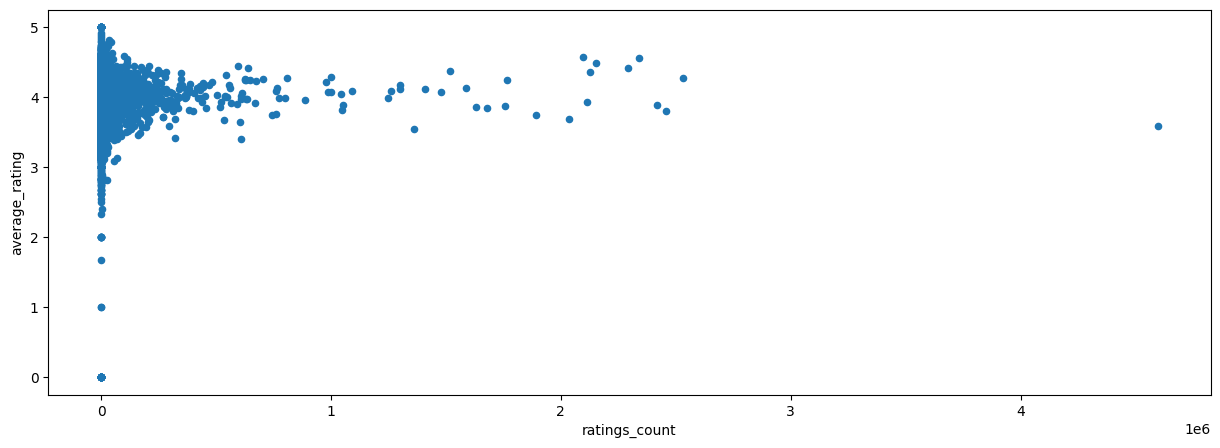

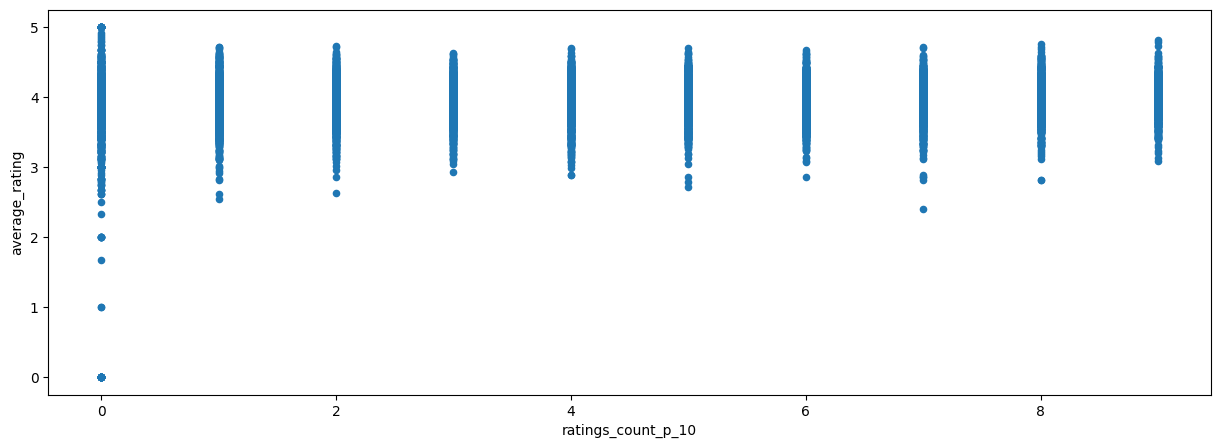

In [26]:
df_outliers_Q = df.copy()
vars = ["num_pages", "ratings_count", "text_reviews_count"]
p = 10
for var in vars:
    var_Q = pd.qcut(df_outliers_Q[var], p, labels=False)
    var_Q = var_Q.rename(f"{var}_p_{p}")
    df_outliers_Q = pd.concat([df_outliers_Q, var_Q], axis=1)

# Scatter plot
df_outliers_Q.plot.scatter(x="ratings_count", y="average_rating", figsize=(15,5))
df_outliers_Q.plot.scatter(x="ratings_count_p_10", y="average_rating", figsize=(15,5))

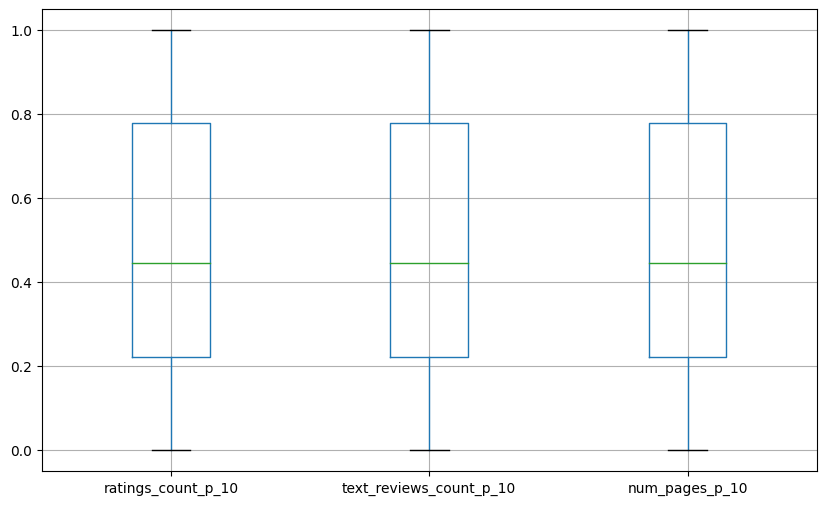

In [27]:
var2 = ["ratings_count_p_10", "text_reviews_count_p_10", "num_pages_p_10"]
# Create varsToNormalize, where all the varsToNormalize values are treated as floats
varsToNormalized = df_outliers_Q[var2].values.astype(float)

# Create an object to transform the data to fit minmax processor
vars_Scaled = preprocessing.MinMaxScaler().fit_transform(varsToNormalized)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(vars_Scaled)

plt.figure(figsize = (10, 6))

df_normalized.boxplot()
plt.xticks([1, 2, 3], var2)
plt.show()

# Code adapted from: https://github.com/kart-projects/Goodreads-books/blob/master/DataExploration.ipynb

Maybe these new features will be better to train the model, we will find out later. To summarize, we will pre-process our numeric variables to get new features that are more balanced as shown in the table below

| Variable | Pre-processing
| --- | --- |
| ```ratings_count``` | Quantile Regrouping |
| ```text_reviews_count``` | Quantile Regrouping |
| ```num_pages``` | Quantile Regrouping |
| ```average_rating``` | None |

/!\ **Note** We do not know if the new features through quantiles regrouping will be useful and this will be tested upon training and through some correlation matrices in the feature selection section.